For the first step we will import every function needed in our code , we will work basically with Tensorflow Library where we will use it for a simple CNN , then for an Hybrid Model (CNN+RNN) , then for a pre-trained vgg16 model and finally for a ResNet50 pre-trained Model.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, Conv1D, Reshape, MaxPooling1D, TimeDistributed, Bidirectional
from keras.layers import Input
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



In [3]:
img_height, img_width = 224, 224
batch_size = 32
data_dir = 'FCGR_Analysiss_k5'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2032 images belonging to 2 classes.
Found 580 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


In [5]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [6]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
]

history_cnn = cnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/100
64/64 [==============================] - 53s 824ms/step - loss: 0.7011 - accuracy: 0.5207 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 49s 768ms/step - loss: 0.6925 - accuracy: 0.5103 - val_loss: 0.6914 - val_accuracy: 0.5034 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 46s 713ms/step - loss: 0.6916 - accuracy: 0.5064 - val_loss: 0.6912 - val_accuracy: 0.5034 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 46s 724ms/step - loss: 0.6888 - accuracy: 0.5374 - val_loss: 0.6883 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 48s 757ms/step - loss: 0.6853 - accuracy: 0.5527 - val_loss: 0.6788 - val_accuracy: 0.6155 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 49s 770ms/step - loss: 0.6733 - accuracy: 0.6004 - val_loss: 0.6675 - val_accuracy: 0.6241 - lr: 1.0000e-04
Epoch 7/100
64/64 [===============

In [7]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

10/10 [==============================] - 3s 310ms/step - loss: 0.3181 - accuracy: 0.8973
Test Accuracy: 89.73%


The CNN model for Kmers=5 has performed exceptionally well on the test set, achieving an accuracy of 89.73%. This high level of accuracy, along with a low test loss, suggests that the model is both effective and reliable.
The consistency between validation and test performance indicates good generalization, an essential characteristic for deploying the model in practical applications.
Overall, the results demonstrate that the model has effectively learned to classify the data and can be considered successful for the given task. Further improvements could still be explored to enhance performance and robustness, but the current model already shows a high degree of proficiency.

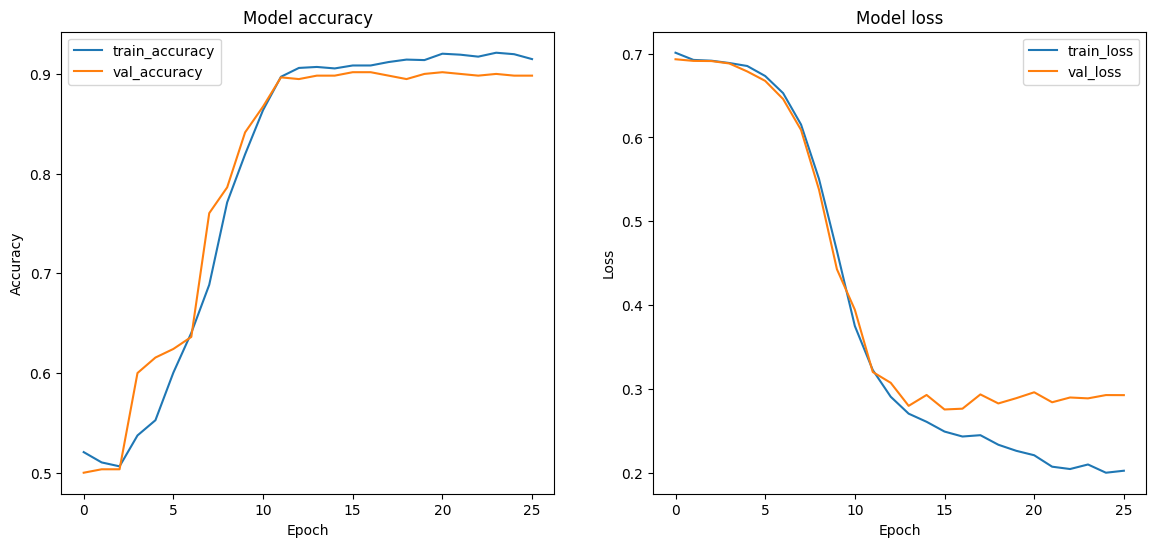

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_cnn.history['accuracy'], label='train_accuracy')
ax1.plot(history_cnn.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_cnn.history['loss'], label='train_loss')
ax2.plot(history_cnn.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

10/10 [==============================] - 2s 150ms/step
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       146
           1       0.97      0.82      0.89       146

    accuracy                           0.90       292
   macro avg       0.91      0.90      0.90       292
weighted avg       0.91      0.90      0.90       292



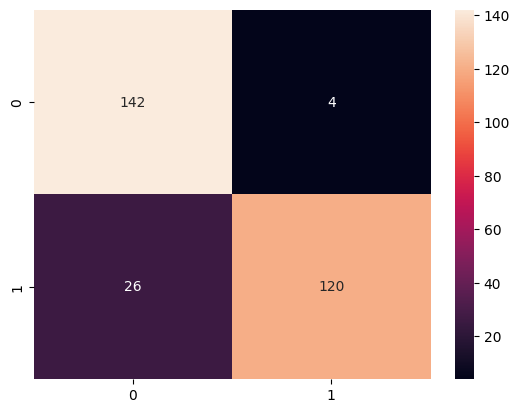

In [9]:
y_pred = cnn_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

The CNN model for Kmers=5 has achieved a high overall accuracy of 90%, with strong precision, recall, and F1-scores for both classes.
The model demonstrates balanced performance, effectively handling both classes without significant bias.
The slight difference in recall between the classes suggests room for minor improvement, particularly in enhancing the recall for class 1.
Overall, the model's performance is robust and reliable, making it well-suited for the classification task at hand.

In [10]:
input_shape = (img_height, img_width, 3)
input_layer = Input(shape=input_shape)

cnn_layer = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten()
])
cnn_output = cnn_layer(input_layer)
cnn_output = Dense(128, activation='relu')(cnn_output)
cnn_output = Dropout(0.5)(cnn_output)
cnn_output = Reshape((128, 1))(cnn_output)
rnn_layer = Bidirectional(LSTM(64))(cnn_output)
output_layer = Dense(1, activation='sigmoid')(rnn_layer)

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn_rnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 86528)             93248     
                                                                 
 dense_2 (Dense)             (None, 128)               11075712  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                             

In [11]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_cnn_rnn_model.h5', save_best_only=True)
]
history_cnn_rnn = cnn_rnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
64/64 [==============================] - 54s 806ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 50s 773ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6930 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 48s 754ms/step - loss: 0.6935 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 48s 752ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 49s 761ms/step - loss: 0.6931 - accuracy: 0.4995 - val_loss: 0.6929 - val_accuracy: 0.5793 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 48s 757ms/step - loss: 0.6933 - accuracy: 0.5113 - val_loss: 0.6926 - val_accuracy: 0.5017 - lr: 1.0000e-04
Epoch 7/100
64/64 [===============

In [13]:
test_loss, test_acc = cnn_rnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


10/10 [==============================] - 3s 250ms/step - loss: 0.2889 - accuracy: 0.9007
Test Accuracy: 90.07%


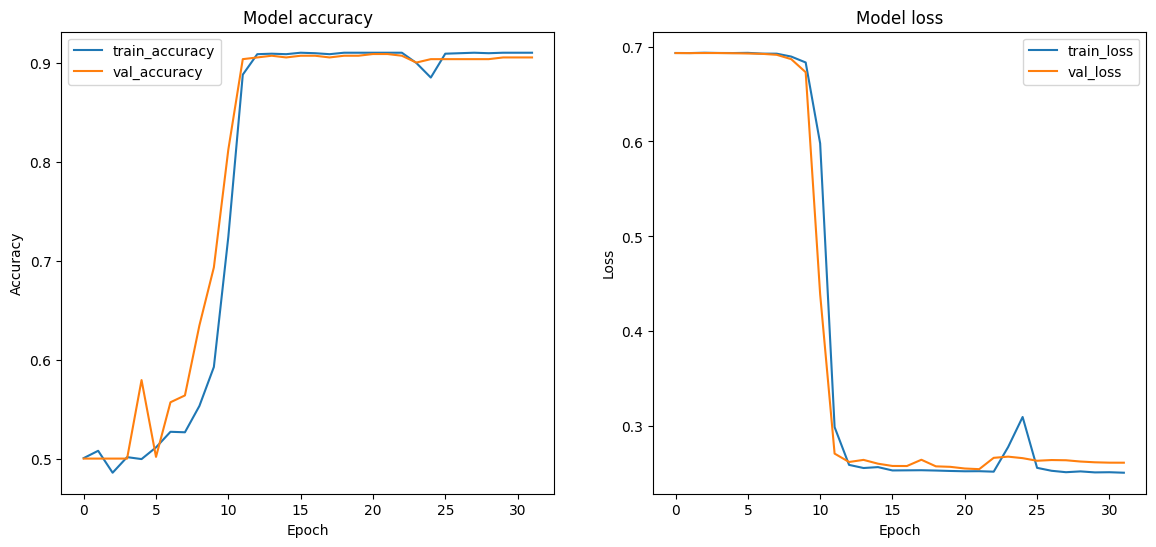

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_cnn_rnn.history['accuracy'], label='train_accuracy')
ax1.plot(history_cnn_rnn.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_cnn_rnn.history['loss'], label='train_loss')
ax2.plot(history_cnn_rnn.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

10/10 [==============================] - 4s 235ms/step
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       146
           1       0.99      0.81      0.89       146

    accuracy                           0.90       292
   macro avg       0.91      0.90      0.90       292
weighted avg       0.91      0.90      0.90       292



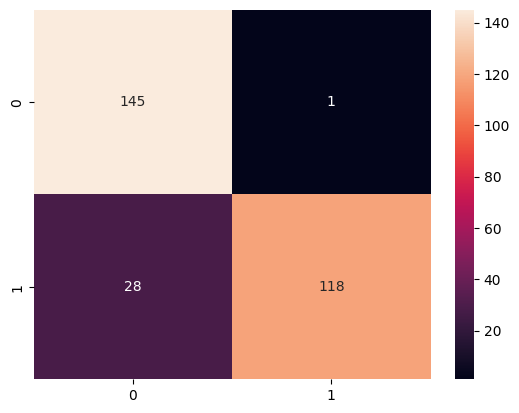

In [15]:
y_pred = cnn_rnn_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [16]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

vgg16_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_vgg16_model.h5', save_best_only=True)
]

history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
64/64 [==============================] - 176s 3s/step - loss: 0.7384 - accuracy: 0.4936 - val_loss: 0.6895 - val_accuracy: 0.5448 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 169s 3s/step - loss: 0.6959 - accuracy: 0.5123 - val_loss: 0.6906 - val_accuracy: 0.5190 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 169s 3s/step - loss: 0.6924 - accuracy: 0.5300 - val_loss: 0.6919 - val_accuracy: 0.5017 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 169s 3s/step - loss: 0.6933 - accuracy: 0.5094 - val_loss: 0.6894 - val_accuracy: 0.5810 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 169s 3s/step - loss: 0.6916 - accuracy: 0.5138 - val_loss: 0.6882 - val_accuracy: 0.5741 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 170s 3s/step - loss: 0.6892 - accuracy: 0.5384 - val_loss: 0.6866 - val_accuracy: 0.5690 - lr: 1.0000e-04
Epoch 7/100
64/64 [===========================

In [18]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

10/10 [==============================] - 20s 2s/step - loss: 0.5386 - accuracy: 0.7226
Test Accuracy: 72.26%


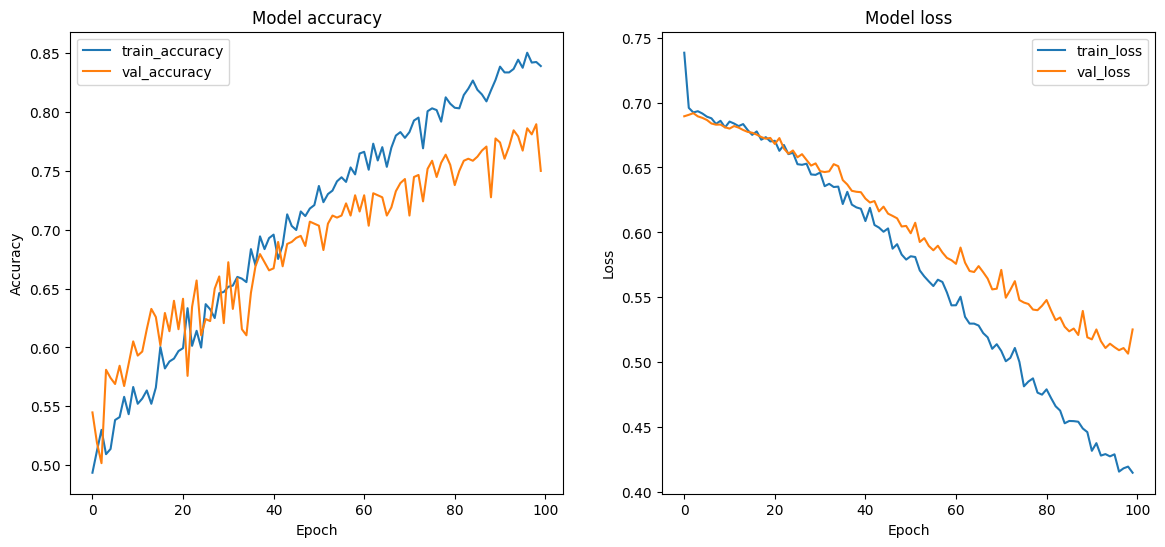

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_vgg16.history['accuracy'], label='train_accuracy')
ax1.plot(history_vgg16.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(history_vgg16.history['loss'], label='train_loss')
ax2.plot(history_vgg16.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

10/10 [==============================] - 20s 2s/step
              precision    recall  f1-score   support

           0       0.66      0.93      0.77       146
           1       0.88      0.51      0.65       146

    accuracy                           0.72       292
   macro avg       0.77      0.72      0.71       292
weighted avg       0.77      0.72      0.71       292



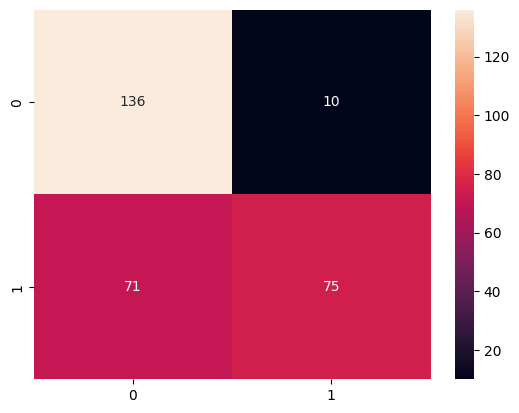

In [20]:
y_pred = vgg16_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [21]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in resnet50_base.layers:
    layer.trainable = False

resnet50_model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

resnet50_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
resnet50_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________


In [22]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_resnet50_model.h5', save_best_only=True)
]

history_resnet50 = resnet50_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
64/64 [==============================] - 176s 3s/step - loss: 0.8782 - accuracy: 0.5167 - val_loss: 0.6937 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 172s 3s/step - loss: 0.6987 - accuracy: 0.4857 - val_loss: 0.6930 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 168s 3s/step - loss: 0.6939 - accuracy: 0.4902 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 169s 3s/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.4983 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 168s 3s/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4983 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 169s 3s/step - loss: 0.6931 - accuracy: 0.5084 - val_loss: 0.6930 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/100
64/64 [===========================

In [23]:
test_loss, test_acc = resnet50_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


10/10 [==============================] - 18s 2s/step - loss: 0.6929 - accuracy: 0.5000
Test Accuracy: 50.00%


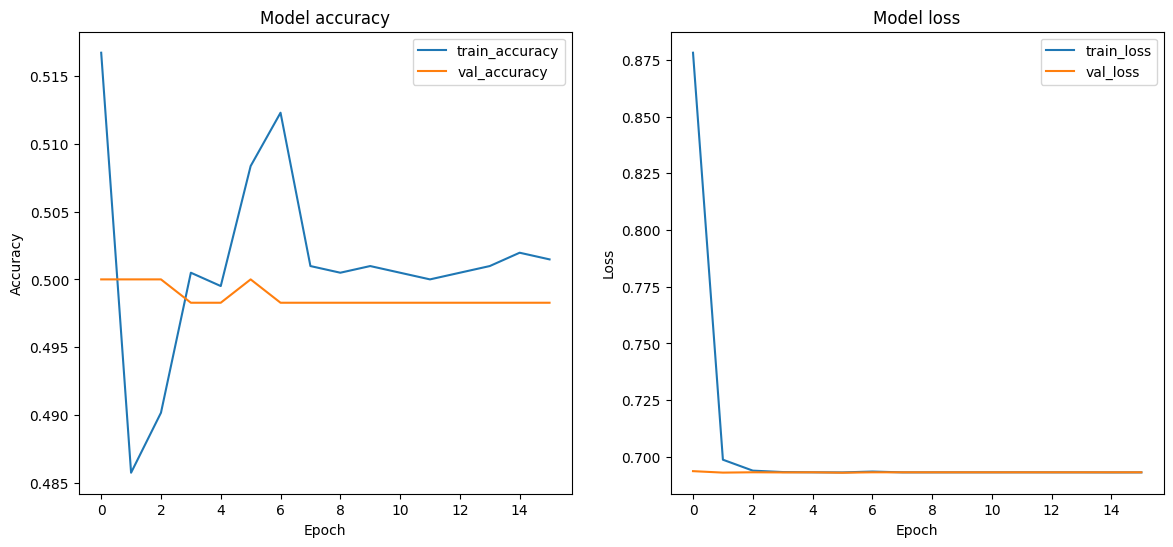

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_resnet50.history['accuracy'], label='train_accuracy')
ax1.plot(history_resnet50.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_resnet50.history['loss'], label='train_loss')
ax2.plot(history_resnet50.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

10/10 [==============================] - 19s 2s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       146
           1       0.50      1.00      0.67       146

    accuracy                           0.50       292
   macro avg       0.25      0.50      0.33       292
weighted avg       0.25      0.50      0.33       292



C:\Users\Badis\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Badis\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Badis\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


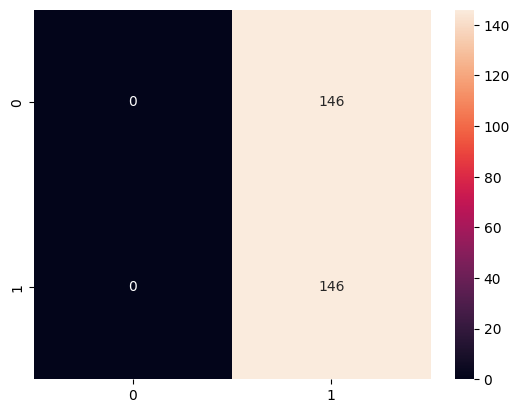

In [25]:
y_pred = resnet50_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()